In [1]:
import cudf as pd
import cupy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cuml.ensemble import RandomForestRegressor
from cuml.model_selection import train_test_split
from cuml.preprocessing import StandardScaler
from cuml.metrics import mean_squared_error

### Read Data

In [2]:
file_path = "data.csv"
df = pd.read_csv(file_path)

df.shape

(955109, 22)

### Basic Statistical Information

In [3]:
df.describe()

,id,Monsoon Intensity,Terrain Drainage,River Management,Deforestation,rbanization,Climate Change,Dam Quality,Sedimentation,Agricultural Practices,...,Drainage System,Coastal Vulnerability,Landslide,Watershed,Infrastructure Deterioration,Population Score,Wetland Loss,Inadequate Planning,Policy Factors,Flood Probability
count,9.551090e+05,955109.000000,955109.000000,955109.000000,955109.000000,955109.000000,955109.000000,955109.000000,955109.000000,955109.000000,...,955109.000000,955109.000000,955109.000000,955109.000000,955109.000000,955109.000000,955109.000000,955109.000000,955109.000000,955109.000000
mean,5.243930e+05,4.873737,4.913153,4.943319,4.899035,4.931001,4.892444,4.942098,4.882214,4.931760,...,4.933038,4.940768,4.918491,4.916968,4.881305,4.882116,4.938287,4.927668,4.927720,0.502102
std,3.027614e+05,1.962609,2.048069,2.027258,1.963880,2.036066,1.971409,2.034013,1.976639,2.026222,...,2.023803,2.042013,2.034159,2.036680,1.977363,1.983782,2.023786,2.035899,2.045187,0.049751
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.355000
25%,2.621420e+05,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,...,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,0.470000
50%,5.245520e+05,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.500000
75%,7.866700e+05,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,0.535000
max,1.048574e+06,10.000000,11.000000,11.000000,10.000000,11.000000,10.000000,11.000000,10.000000,11.000000,...,11.000000,11.000000,11.000000,11.000000,10.000000,10.000000,11.000000,11.000000,11.000000,0.650000


### Preparing the Data

In [4]:
target_column = "Flood Probability"

X = df.drop(["id", target_column], axis=1)
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Training

In [5]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

/home/jiaokan/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/jiaokan/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RandomForestRegressor()

In [6]:
rf_model.convert_to_treelite_model().to_treelite_checkpoint("./model.tl")

### Sorting by the Importances of each Feature

In [7]:
baseline_predictions = rf_model.predict(X_test_scaled)
baseline_mse = mean_squared_error(y_test, baseline_predictions)


def permutation_importance(model, X, y, baseline_mse):
    importances = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, i])
        permuted_predictions = model.predict(X_permuted)
        permuted_mse = mean_squared_error(y, permuted_predictions)

        importances[i] = permuted_mse - baseline_mse
        # Permuted by shuffling is expected to lower the accuracy, in other words, MSE of permuted data is expected to be bigger.
        # Therefore, we put it in front of MSE of the baseline, to keep all the importances are above zero.
        # If there exists any importance below zero then, then either you are very unlucky, or your dataset is too small or problematic.

    return importances


X_test_cupy = X_test_scaled.to_cupy()
y_test_cupy = y_test.to_cupy()

importances = permutation_importance(rf_model, X_test_cupy, y_test_cupy, baseline_mse)

importances_np = importances.get()

feature_importance = pd.DataFrame(
    {"feature": X.columns, "importance": importances_np}
).sort_values("importance", ascending=False)

feature_importance = feature_importance.to_pandas()

feature_importance.style.format({"importance": "{:.8f}"}).background_gradient(
    cmap="coolwarm"
)

,feature,importance
1,Terrain Drainage,0.00013960
2,River Management,0.00013701
6,Dam Quality,0.00013142
10,Ineffective Disaster Prevention,0.00012135
13,Landslide,0.00011930
8,Agricultural Practices,0.00011779
7,Sedimentation,0.00011335
4,rbanization,0.00011170
15,Infrastructure Deterioration,0.00011162
14,Watershed,0.00011146


The last one is too small, so ignore it to have a better view.

In [8]:
feature_importance[:-1].style.format({"importance": "{:.8f}"}).background_gradient(
    cmap="coolwarm"
)

,feature,importance
1,Terrain Drainage,0.00013960
2,River Management,0.00013701
6,Dam Quality,0.00013142
10,Ineffective Disaster Prevention,0.00012135
13,Landslide,0.00011930
8,Agricultural Practices,0.00011779
7,Sedimentation,0.00011335
4,rbanization,0.00011170
15,Infrastructure Deterioration,0.00011162
14,Watershed,0.00011146


### Barplot of Importances

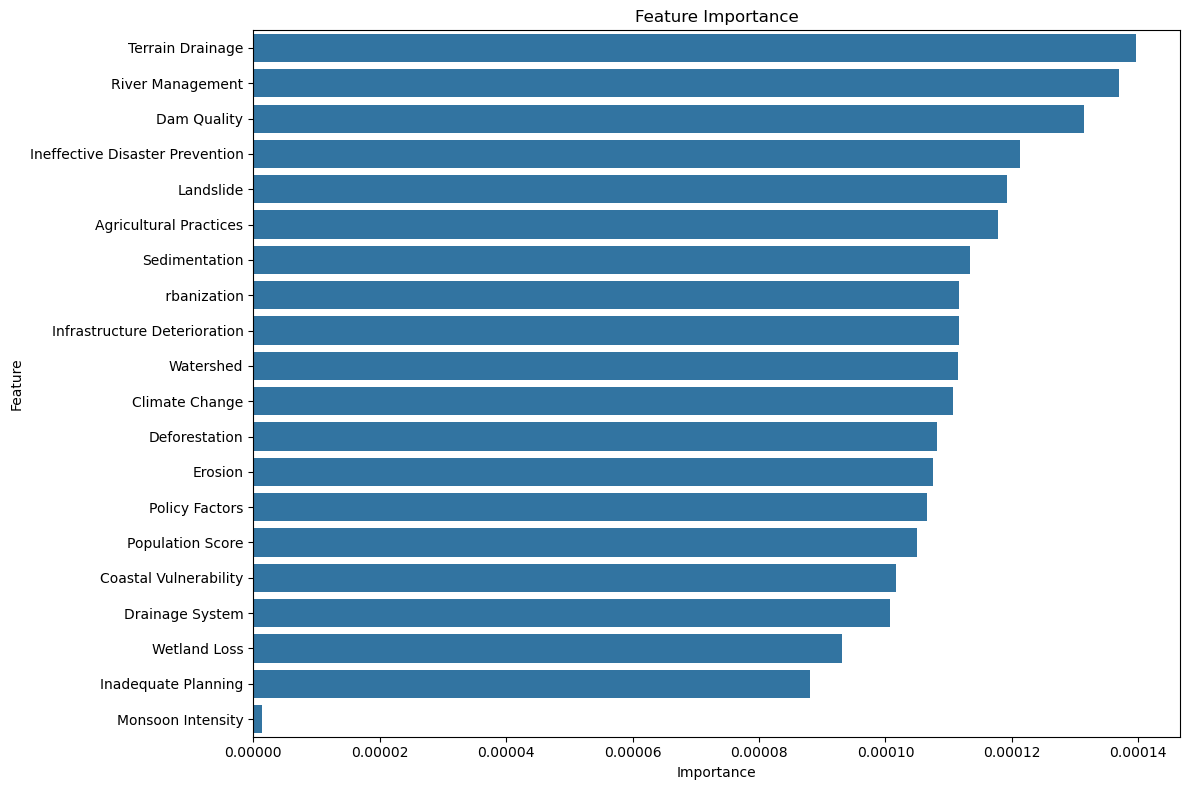

In [9]:
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Distribution of Importances

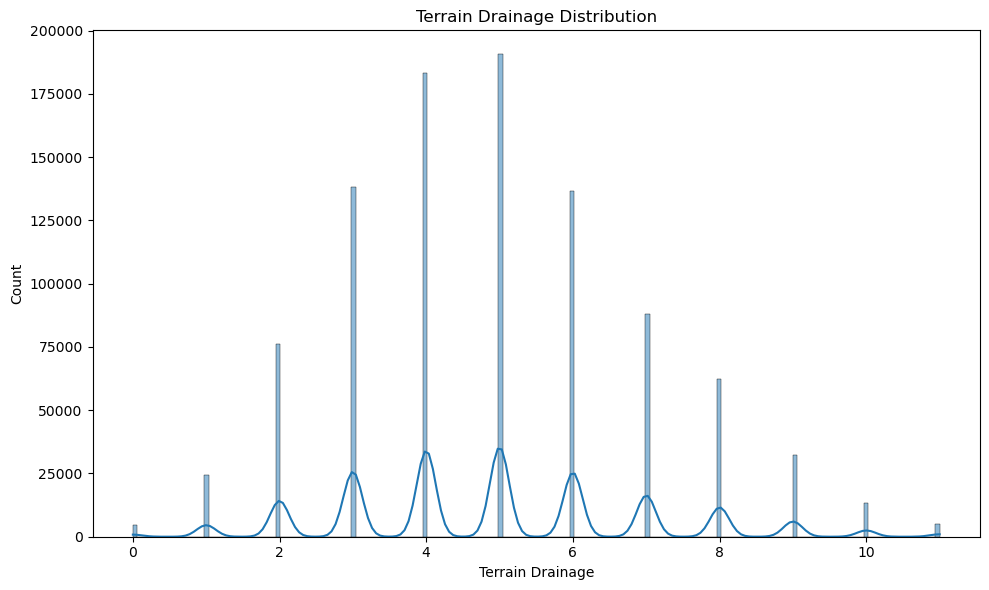

In [11]:
df = df.to_pandas()  # Convert cuDF to normal pandas
most_important_feature = feature_importance["feature"].iloc[0]
plt.figure(figsize=(10, 6))
sns.histplot(df[most_important_feature], kde=True)
plt.title(f"{most_important_feature} Distribution")
plt.tight_layout()
plt.show()

### Scatter Plot between Most Important Feature and Flood

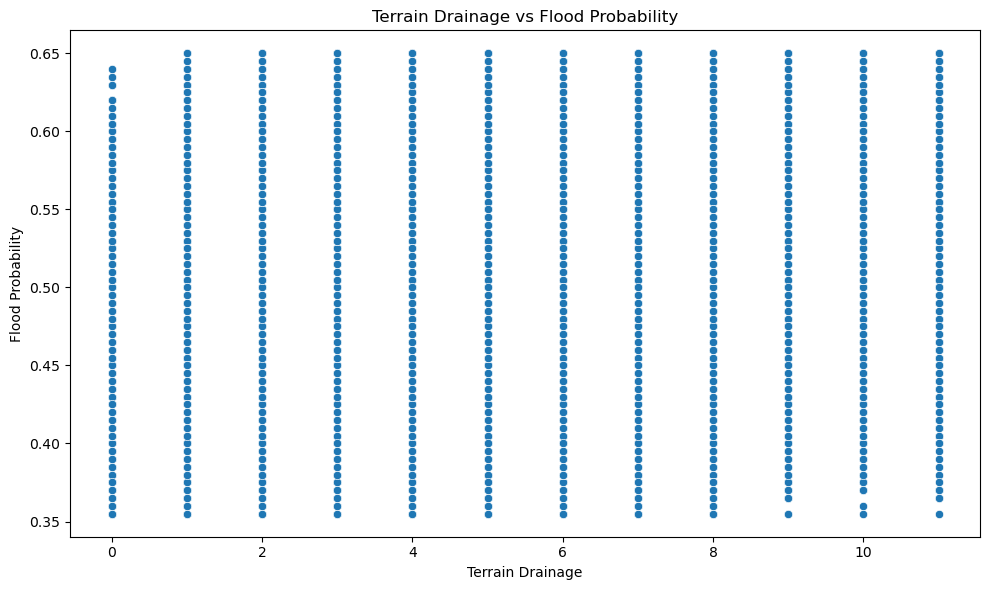

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=most_important_feature, y=target_column)
plt.title(f"{most_important_feature} vs {target_column}")
plt.tight_layout()
plt.show()